## Install and import Necessary Libraries

In [53]:
#!pip install pyLDAvis
#!pip install gensim
#!pip install wordcloud matplotlib
import pyLDAvis # package to interept the topics in a topic model
import pyLDAvis.gensim_models #python library for the interactive topic model visualization

import gensim #open-source library for unsupervised topic modeling,document indexing
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import gensim.corpora as corpora #for mapping words to integers

import nltk #python tool kit for NLP
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords #for removing stop words

import pickle #for html export
import pandas as pd 
import os 
import re #regular expression library
from wordcloud import WordCloud #for generating word clouds

import warnings 
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akhil.000\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\akhil.000\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load and Read the Dataset

In [54]:
papers = pd.read_csv(r"papers.csv")
print("The shape of data --->",papers.shape)
papers.head(10) # Print head

The shape of data ---> (6560, 7)


,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."
5,1002,1994,Using a neural net to instantiate a deformable...,NaN,1002-using-a-neural-net-to-instantiate-a-defor...,Abstract Missing,U sing a neural net to instantiate a\ndeformab...
6,1003,1994,Plasticity-Mediated Competitive Learning,NaN,1003-plasticity-mediated-competitive-learning.pdf,Abstract Missing,Plasticity-Mediated Competitive Learning\n\nTe...
7,1004,1994,ICEG Morphology Classification using an Analog...,NaN,1004-iceg-morphology-classification-using-an-a...,Abstract Missing,ICEG Morphology Classification using an\nAnalo...
8,1005,1994,Real-Time Control of a Tokamak Plasma Using Ne...,NaN,1005-real-time-control-of-a-tokamak-plasma-usi...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...
9,1006,1994,Pulsestream Synapses with Non-Volatile Analogu...,NaN,1006-pulsestream-synapses-with-non-volatile-an...,Abstract Missing,Real-Time Control of a Tokamak Plasma\nUsing N...


In [55]:
# Drop columns if they exist
columns_to_drop = ['id', 'event_type', 'pdf_name']
for col in columns_to_drop:
    if col in papers.columns:
        papers = papers.drop(columns=col)

#Sample 200 rows
sample_text = 200
papers = papers.sample(sample_text)

# Remove punctuation/lower casing
papers['paper_text_processed'] = papers['paper_text'].map(lambda x: re.sub(r'[,.!?]', '', x))

print(papers.head())


      year                                              title  \
2767  2008  Designing neurophysiology experiments to optim...   
5595  2016                    Structure-Blind Signal Recovery   
2143  2005                    Prediction and Change Detection   
3910  1991  Gradient Descent: Second Order Momentum and Sa...   
1148  2001  The Intelligent surfer: Probabilistic Combinat...   

                                               abstract  \
2767                                   Abstract Missing   
5595  We consider the problem of recovering a signal...   
2143                                   Abstract Missing   
3910                                   Abstract Missing   
1148                                   Abstract Missing   

                                             paper_text  \
2767  Designing neurophysiology experiments to optim...   
5595  Structure-Blind Signal Recovery\n\nDmitry Ostr...   
2143  Prediction and Change Detection\nMark Steyvers...   
3910  Gradient Des

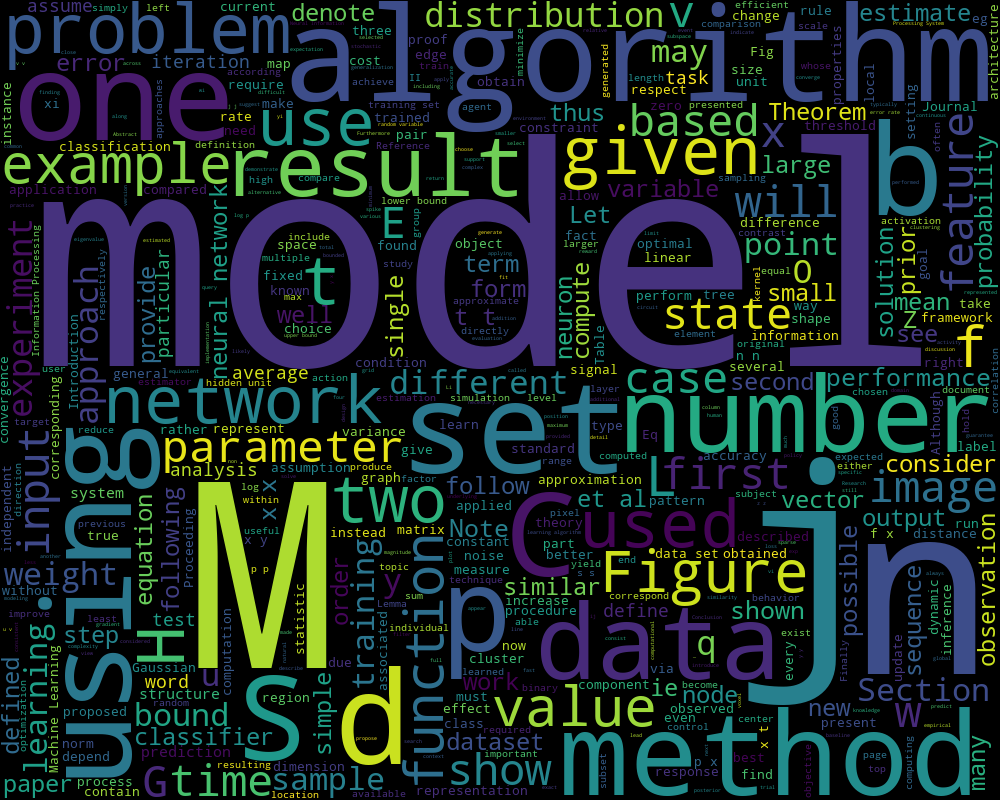

In [56]:
# Join the different processed title together.
long_string = ','.join(list(papers['paper_text_processed'].values))

#Create a WordCloud object
wordcloud = WordCloud(background_color="black" ,max_words=500,contour_width=3, contour_color='steelblue',width=1000,height=800)

#Genearte a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

## Data Pre-processing 

In [57]:
# Define stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'used', 'using', 'use', 'model', 'one', 'two', 'set'])

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function for converting sentences to words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Function for removing stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Function for lemmatizing words
def lemmatize_words(texts):
    return [[lemmatizer.lemmatize(word) for word in doc] for doc in texts]

# Function for building bigrams and trigrams
def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#'papers' is a DataFrame and 'paper_text_processed' is a column with text data
data = papers.paper_text_processed.values.tolist()  # Creating the array of tokens
data_words = list(sent_to_words(data))  # Converting them into list

data_words = remove_stopwords(data_words)  # Remove stop words

# Build bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100)
trigram = Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Apply bigrams and trigrams
data_words = make_bigrams(data_words, bigram_mod)
data_words = make_trigrams(data_words, trigram_mod)

# Lemmatize words
data_words = lemmatize_words(data_words)
print(data_words[:1][0][:30])

['designing', 'neurophysiology', 'experiment', 'optimally', 'constrain', 'receptive_field', 'model', 'along', 'parametric', 'submanifolds', 'jeremy', 'lewi', 'school', 'bioengineering', 'georgia', 'institute_technology', 'jeremy', 'lewius', 'robert', 'butera', 'school', 'electrical', 'computer', 'engineering', 'georgia', 'institute_technology', 'rbutera', 'ecegatechedu', 'david', 'schneider']


## Term Document Frequency

In [58]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Filter extremes to remove too rare and too common words
id2word.filter_extremes(no_below=15, no_above=0.5)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in +texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 3), (5, 1), (6, 1), (7, 7), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 4), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 10), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 3), (29, 2)]


## Model Building and Topic-Word Distribution

In [74]:
# Build LDA model
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=10, 
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=30,
                                   alpha='auto',
                                   per_word_topics=True)

pprint (lda_model.print_topics())


[(0,
  '0.027*"unit" + 0.016*"classifier" + 0.014*"activation" + 0.012*"rule" + '
  '0.012*"architecture" + 0.012*"pattern" + 0.010*"layer" + 0.009*"node" + '
  '0.009*"neural_network" + 0.008*"net"'),
 (1,
  '0.065*"query" + 0.034*"page" + 0.032*"similarity" + 0.026*"word" + '
  '0.018*"score" + 0.016*"document" + 0.012*"metric" + 0.011*"search" + '
  '0.010*"list" + 0.010*"dimension"'),
 (2,
  '0.037*"graph" + 0.033*"edge" + 0.023*"cluster" + 0.016*"clustering" + '
  '0.016*"vertex" + 0.013*"tree" + 0.013*"segment" + 0.012*"node" + '
  '0.010*"distance" + 0.009*"center"'),
 (3,
  '0.021*"neuron" + 0.013*"stimulus" + 0.011*"dynamic" + 0.011*"spike" + '
  '0.009*"response" + 0.008*"activity" + 0.007*"noise" + 0.007*"circuit" + '
  '0.007*"fig" + 0.006*"signal"'),
 (4,
  '0.059*"image" + 0.014*"object" + 0.011*"pixel" + 0.011*"classification" + '
  '0.011*"label" + 0.010*"map" + 0.010*"pose" + 0.009*"accuracy" + '
  '0.008*"face" + 0.008*"trained"'),
 (5,
  '0.019*"policy" + 0.018*"opti

## Document-Topic Distribution

In [79]:
doc_lda = lda_model[corpus]
# Iterate through each document's topic distribution
for i, doc in enumerate(doc_lda):
    print(f"Document {i+1}:")
    for topic_id, topic_prob in doc[0]:
        print(f"  Topic {topic_id}: Probability {topic_prob:.4f}")
    print("\n")

Document 1:
  Topic 3: Probability 0.3803
  Topic 5: Probability 0.0119
  Topic 6: Probability 0.4673
  Topic 7: Probability 0.1371


Document 2:
  Topic 3: Probability 0.0366
  Topic 4: Probability 0.0313
  Topic 6: Probability 0.1763
  Topic 8: Probability 0.2993
  Topic 9: Probability 0.4562


Document 3:
  Topic 3: Probability 0.1946
  Topic 5: Probability 0.0944
  Topic 7: Probability 0.6437
  Topic 8: Probability 0.0666


Document 4:
  Topic 0: Probability 0.0995
  Topic 2: Probability 0.0430
  Topic 3: Probability 0.3793
  Topic 5: Probability 0.4065
  Topic 8: Probability 0.0710


Document 5:
  Topic 0: Probability 0.0779
  Topic 1: Probability 0.7408
  Topic 2: Probability 0.0569
  Topic 7: Probability 0.0872
  Topic 8: Probability 0.0366


Document 6:
  Topic 0: Probability 0.0159
  Topic 2: Probability 0.0769
  Topic 6: Probability 0.0193
  Topic 7: Probability 0.8777


Document 7:
  Topic 3: Probability 0.1742
  Topic 4: Probability 0.1170
  Topic 6: Probability 0.2243
  To

## Visualization

In [76]:
# Visualize the topics
LDAvis_data_filepath = os.path.join('./ldavis_prepared_' + str(10))
if not os.path.exists(LDAvis_data_filepath):
    os.makedirs(LDAvis_data_filepath, exist_ok=True)

# Create LDA visualization
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

# Save the prepared data to disk
pyLDAvis.save_html(LDAvis_prepared, os.path.join(LDAvis_data_filepath, 'lda.html'))

# To load the visualization in a notebook:
pyLDAvis.display(LDAvis_prepared)


## Sample Output

In [77]:
num_topics = 10  # Set the number of topics you used
num_words = 10   # Number of top words to display for each topic

for i in range(num_topics):
    topic_words = lda_model.show_topic(i, num_words)
    print(f"Topic {i+1}: {', '.join([word for word, prob in topic_words])}")


Topic 1: unit, classifier, activation, rule, architecture, pattern, layer, node, neural_network, net
Topic 2: query, page, similarity, word, score, document, metric, search, list, dimension
Topic 3: graph, edge, cluster, clustering, vertex, tree, segment, node, distance, center
Topic 4: neuron, stimulus, dynamic, spike, response, activity, noise, circuit, fig, signal
Topic 5: image, object, pixel, classification, label, map, pose, accuracy, face, trained
Topic 6: policy, optimization, action, gradient, cost, reward, iteration, convergence, objective, stochastic
Topic 7: norm, sparse, gaussian, estimation, estimator, variance, eq, user, assumption, group
Topic 8: prior, inference, topic, posterior, bayesian, agent, prediction, node, likelihood, tree
Topic 9: bound, theorem, lemma, proof, empirical, label, noise, generalization, dimension, xt
Topic 10: classifier, classification, constraint, signal, loss, yi, svm, wi, bayes, li


## Computing Coherence Score

In [78]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4579229727014439
